# **Predicting Chest Pain Type from Health Data**

## **Introduction**

Heart disease refers to a group of conditions that affect the heart. As one of the leading global causes of death, early diagnosis is crucial to help save lives (Smith, 2012). Interestingly, chest pain type is linked to heart disease type, thus, classifying chest pain type may be effective in diagnosing heart diseases. Using patients' recorded health data, we will classify chest pain into three categories (anginal, non-anginal, or asymptomatic) to answer the question: How are resting blood pressure, age, and maximum heart rate achieved related to a patient's chest pain type, and how accurately can a patient's chest pain type be predicted with these data? We are using the Heart Disease dataset, containing observations linked to heart diseases, to answer our question. The dataset includes data from Cleveland, Hungary, Switzerland, and VA Long Beach, which we combined into a single data frame.

#### **Abbreviations**
- **KNN:** K-nearest neighbours

## **Methods**

Our objective was to classify a person's chest paint type based on their resting blood pressure, age, and maximum heart rate achieved (all distinct, quantitative characteristics). Our classifier, encompassing data preprocessing, model training, and class prediction, utilized a K-nearest neighbours classification model (which uses supervised learning). Given the absence of a specific chest pain type of interest, the primary performance metric used to evaluate performance was accuracy.

To fulfil our objective, we first read our datasets from the web (GitHub), wrangled them into tidy formats with proper column labels and clean data, and joined them into one data frame. Then, we explored relationships in our data (through summary tables and various plots) to determine which variables may be used to predict chest pain type. Based on our findings (and a lack of useable variables), we chose our predictor variables and eliminated any irrelevant columns from our data frame, filtering out any rows which were missing data. From that point, we began building our classification model. We split our data into training and testing sets, using the training set to build an initial KNN classification model, tune it utilizing cross-validation, and produce and fit our final model with the best K value (from tuning). Finally, we used our fitted model to predict on test data and reported the model’s accuracy. Using the results of our classification, we then produced plots to visualize the data analys (described below)ite.

## **Data Analysis**

In [1]:
library(tidyverse)
library(tidymodels)
library(RColorBrewer)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

### **Data Reading/Wrangling/Cleaning**

To work with, and make sense of, our data, we first read and wrangle it into a tidy format, reclassifying and renaming variables as appropriate.

In [2]:
options(repr.plot.width = 8, repr.plot.height = 8)

sws_url <- "https://raw.github.com/aaelbaz/DSCI-100-Group-Project/215e081060c7280c1d975721f1934d3c147aa8fe/heart_disease_data/processed.switzerland.data"
clv_url <- "https://raw.github.com/aaelbaz/DSCI-100-Group-Project/215e081060c7280c1d975721f1934d3c147aa8fe/heart_disease_data/processed.cleveland.data"
hgr_url <- "https://raw.github.com/aaelbaz/DSCI-100-Group-Project/215e081060c7280c1d975721f1934d3c147aa8fe/heart_disease_data/processed.hungarian.data"
vlb_url <- "https://raw.github.com/aaelbaz/DSCI-100-Group-Project/215e081060c7280c1d975721f1934d3c147aa8fe/heart_disease_data/processed.va.data"

cols <- c("age", "sex", "cp_type", "rest_bp", "cholesterol", "fbs", "rest_ecg", "max_hr",
          "exercise_angina", "st_depression", "st_slope", "coloured_vsls", "thal", "heart_disease")
na_vals <- c("", "NA", "?", -9.0)

sws <- read_csv(sws_url, col_names = cols, na = na_vals, show_col_types = FALSE) |> mutate(location = "Switzerland")
clv <- read_csv(clv_url, col_names = cols, na = na_vals, show_col_types = FALSE) |> mutate(location = "Cleveland")
hgr <- read_csv(hgr_url, col_names = cols, na = na_vals, show_col_types = FALSE) |> mutate(location = "Hungary")
vlb <- read_csv(vlb_url, col_names = cols, na = na_vals, show_col_types = FALSE) |> mutate(location = "VA Long Beach")

heart_disease_data <- bind_rows(sws, clv, hgr, vlb)

heart_disease_data$sex <- ifelse(heart_disease_data$sex == 0, "female", "male")
heart_disease_data$cp_type <- ifelse(heart_disease_data$cp_type == 1, "anginal",
                                     ifelse(heart_disease_data$cp_type == 2, "anginal",
                                            ifelse(heart_disease_data$cp_type == 3, "non-anginal", "asymptomatic")))
heart_disease_data$rest_ecg <- ifelse(heart_disease_data$rest_ecg == 0, "normal",
                                      ifelse(heart_disease_data$rest_ecg == 1, "abnormality", "hypertrophy"))
heart_disease_data$exercise_angina <- ifelse(heart_disease_data$exercise_angina == 0, "no", "yes")
heart_disease_data$st_slope <- ifelse(heart_disease_data$st_slope == 1, "upsloping",
                                      ifelse(heart_disease_data$st_slope == 2, "flat", "downsloping"))
heart_disease_data$thal <- ifelse(heart_disease_data$thal == 3, "normal",
                                      ifelse(heart_disease_data$thal == 6, "fixed", "reversable"))

heart_disease_data <- heart_disease_data |> mutate(sex = as.factor(sex), cp_type = as.factor(cp_type), fbs = as.factor(fbs), rest_ecg = as.factor(rest_ecg),
                                                   exercise_angina = as.factor(exercise_angina), st_slope = as.factor(st_slope), thal = as.factor(thal),
                                                   heart_disease = as.factor(heart_disease), location = as.factor(location))

"Table 1: Heart Disease Data"
head(heart_disease_data)

[1] "Table 1: Heart Disease Data"

age,sex,cp_type,rest_bp,cholesterol,fbs,rest_ecg,max_hr,exercise_angina,st_depression,st_slope,coloured_vsls,thal,heart_disease,location
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>
32,male,anginal,95,0,NA,normal,127,no,0.7,upsloping,NA,NA,1,Switzerland
34,male,asymptomatic,115,0,NA,NA,154,no,0.2,upsloping,NA,NA,1,Switzerland
35,male,asymptomatic,NA,0,NA,normal,130,yes,NA,NA,NA,reversable,3,Switzerland
36,male,asymptomatic,110,0,NA,normal,125,yes,1.0,flat,NA,fixed,1,Switzerland
38,female,asymptomatic,105,0,NA,normal,166,no,2.8,upsloping,NA,NA,2,Switzerland
38,female,asymptomatic,110,0,0,normal,156,no,0.0,flat,NA,normal,1,Switzerland


Next, we trim our data frame so that it only contains the variables we need (i.e., our class variable, cp_type, and our three predictor variables). We also eliminate any observations with missing data as is necessary to build our classifier.

In [3]:
heart_disease_clean <- heart_disease_data |>
    select(age, cp_type, rest_bp, max_hr)|>
    filter(!is.na(rest_bp),
           !is.na(age),
           !is.na(cp_type),
           !is.na(max_hr))

"Table 2: Heart Disease Data for Chest Pain Type Classification"
head(heart_disease_clean)

[1] "Table 2: Heart Disease Data for Chest Pain Type Classification"

age,cp_type,rest_bp,max_hr
<dbl>,<fct>,<dbl>,<dbl>
32,anginal,95,127
34,asymptomatic,115,154
36,asymptomatic,110,125
38,asymptomatic,105,166
38,asymptomatic,110,156
38,non-anginal,100,179


We then split our data into a training set (75%) and a testing set (25%) (setting a seed for reproducibility), as is proper practice when building a prediction model. From this point until we are performance testing our final model, we use exclusively training data.

In [4]:
set.seed(1234)

heart_disease_split <- initial_split(heart_disease_clean, prop = 0.75, strata = cp_type)  
heart_disease_train <- training(heart_disease_split)   
heart_disease_test <- testing(heart_disease_split)

### **Exploratory Data Analysis**

This section goes through the exploratory data analysis we conducted, outlining important findings and other relevant information about each figure.

In [5]:
cp_type_summarize <- heart_disease_train |> group_by(cp_type) |>
                        summarize(avg_rest_bp = mean(rest_bp, na.rm = TRUE),
                                  avg_max_hr = mean(max_hr, na.rm = TRUE),
                                  avg_age = mean(age, na.rm = TRUE),
                                  num_cases = n())


"Table 3: Predictor Variable Means and Number of Cases by Chest Pain Type"
cp_type_summarize

[1] "Table 3: Predictor Variable Means and Number of Cases by Chest Pain Type"

cp_type,avg_rest_bp,avg_max_hr,avg_age,num_cases
<fct>,<dbl>,<dbl>,<dbl>,<int>
anginal,132.3333,149.3718,49.91667,156
asymptomatic,131.7829,128.3229,54.57714,350
non-anginal,132.8478,144.1377,52.93478,138


Table 3 above illustrates distinct differences, although subtle, in average resting blood pressure, maximum heart rate achieved, and age between chest pain types. Having multiple predictors with distinct values between classes increases the likelihood of accurate class prediction. The table also shows the number of cases from each class, highlighting the imbalance in cases per chest pain type. There are notably more asymptomatic cases than anginal and non-anginal cases – each equate to about 40% of the asymptomatic cases.

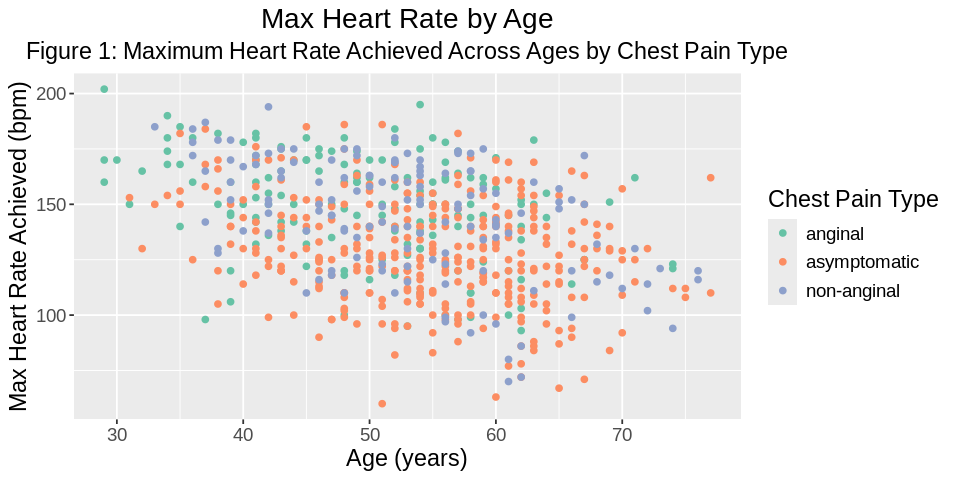

In [6]:
options(repr.plot.width = 8, repr.plot.height= 4)

heart_plot <- heart_disease_train |>
    ggplot(aes(x = age, y = max_hr, color = cp_type)) +
    geom_point() +
    labs(x = "Age (years)", y = "Max Heart Rate Achieved (bpm)", color = "Chest Pain Type") +
    ggtitle("Max Heart Rate by Age", subtitle = "Figure 1: Maximum Heart Rate Achieved Across Ages by Chest Pain Type") +
    scale_color_brewer(palette = "Set2") +
    theme(text = element_text(size = 14), plot.title = element_text(hjust = 0.5), plot.subtitle = element_text(hjust = 0.5))

suppressWarnings(print(heart_plot))

Figure 1 above shows the relationship between max heart rate achieved and age, coloured by chest pain type. This is to demonstrate the distribution/clustering of classes by these predictors. Unfortunately, given the lack of distinctive clusters (i.e., all classes share similar value ranges), classes do not seem highly distinguishable by max heart rate achieved and age.

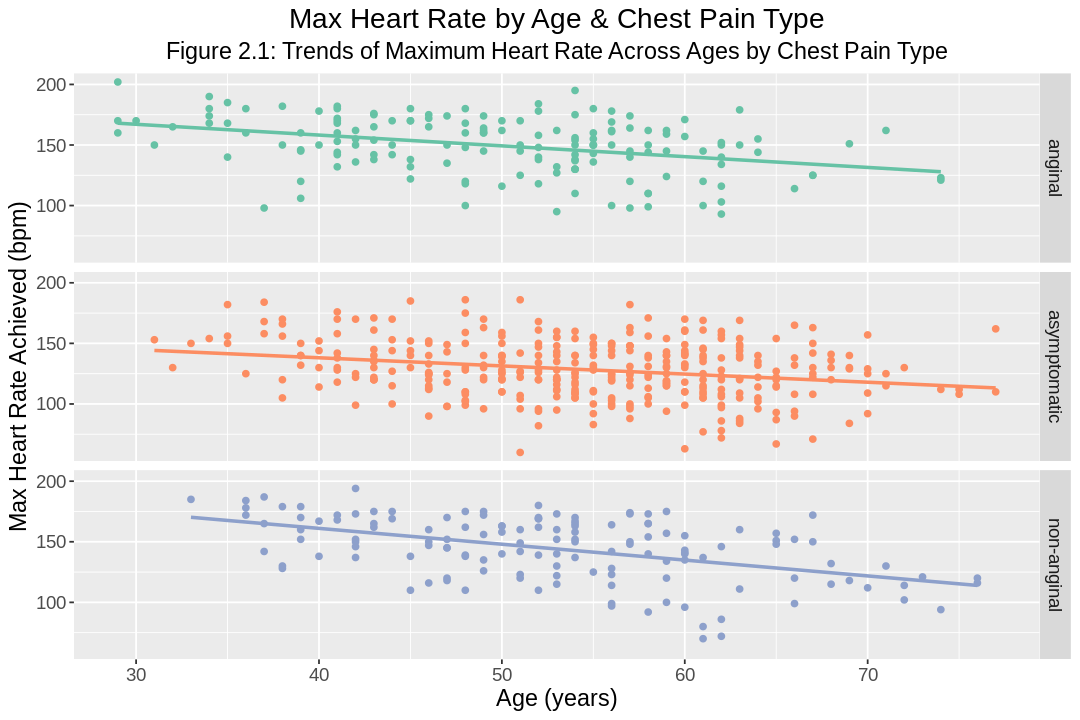

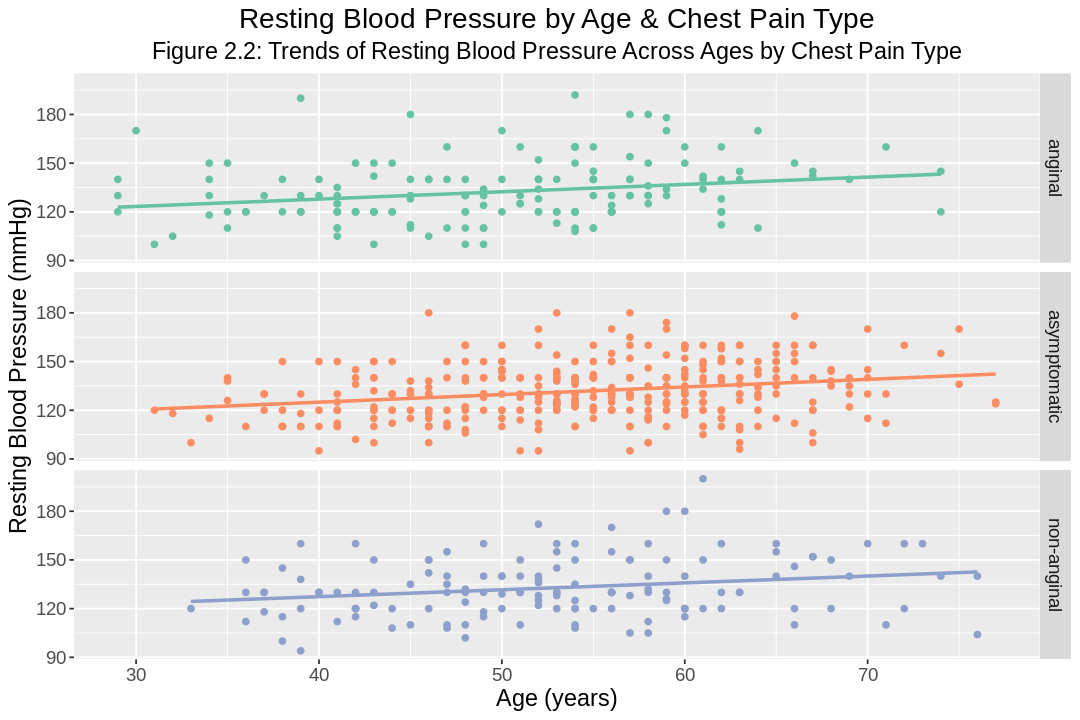

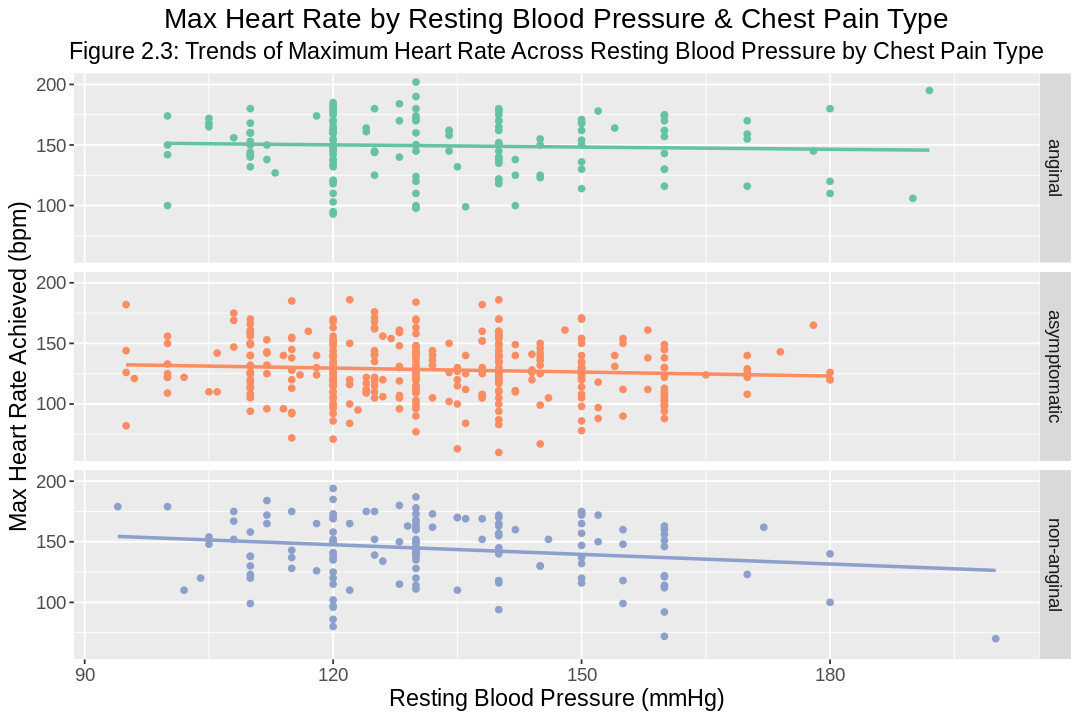

In [7]:
options(repr.plot.width = 9, repr.plot.height = 6)

hr_age_plot <- ggplot(heart_disease_train, aes(x = age, y = max_hr, color = cp_type)) +
                geom_point(show.legend = FALSE) +
                labs(x = "Age (years)", y = "Max Heart Rate Achieved (bpm)", color = "Chest Pain Type") +
                ggtitle("Max Heart Rate by Age & Chest Pain Type",
                       subtitle = "Figure 2.1: Trends of Maximum Heart Rate Across Ages by Chest Pain Type") +
                facet_grid(rows = vars(cp_type)) +
                geom_smooth(method = "lm", se = FALSE, formula = y ~ x, show.legend = FALSE) +
                scale_color_brewer(palette = "Set2") +
                theme(text = element_text(size = 14), plot.title = element_text(hjust = 0.5), plot.subtitle = element_text(hjust = 0.5))
suppressWarnings(print(hr_age_plot))

bp_age_plot <- ggplot(heart_disease_train, aes(x = age, y = rest_bp, color = cp_type)) +
                geom_point(show.legend = FALSE) +
                labs(x = "Age (years)", y = "Resting Blood Pressure (mmHg)", color = "Chest Pain Type") +
                ggtitle("Resting Blood Pressure by Age & Chest Pain Type",
                       subtitle = "Figure 2.2: Trends of Resting Blood Pressure Across Ages by Chest Pain Type") +
                facet_grid(rows = vars(cp_type)) +
                geom_smooth(method = "lm", se = FALSE, formula = y ~ x, show.legend = FALSE) +
                scale_color_brewer(palette = "Set2") +
                theme(text = element_text(size = 14), plot.title = element_text(hjust = 0.5), plot.subtitle = element_text(hjust = 0.5))
suppressWarnings(print(bp_age_plot))

hr_bp_plot <- ggplot(heart_disease_train, aes(x = rest_bp, y = max_hr, color = cp_type)) +
                geom_point(show.legend = FALSE) +
                labs(x = "Resting Blood Pressure (mmHg)", y = "Max Heart Rate Achieved (bpm)", color = "Chest Pain Type") +
                ggtitle("Max Heart Rate by Resting Blood Pressure & Chest Pain Type",
                       subtitle = "Figure 2.3: Trends of Maximum Heart Rate Across Resting Blood Pressure by Chest Pain Type") +
                facet_grid(rows = vars(cp_type)) +
                geom_smooth(method = "lm", se = FALSE, formula = y ~ x, show.legend = FALSE) +
                scale_color_brewer(palette = "Set2") +
                theme(text = element_text(size = 14), plot.title = element_text(hjust = 0.5), plot.subtitle = element_text(hjust = 0.5))
suppressWarnings(print(hr_bp_plot))

The above Figures 2.1–2.3 demonstrate the relationships between each of our predictor variables. Within each figure, the trends for each class are shown to be quite similar.

### **Classification**

Now, we can begin to build our classifier. Before building our final model, we first tune an initial model with cross-validation to find the best K-value (number of neighbours considered); that is, the K-value that will result in the highest accuracy. As cross-validation using the vfold_cv() function utilizes randomness, we must set a seed to make our results exactly reproducible (while still using random selection as opposed to manual, potentially biased selection).

In [8]:
set.seed(1234)

heart_disease_recipe <- recipe(cp_type ~ rest_bp + age + max_hr, data = heart_disease_train) |>
                    step_scale(all_predictors()) |>
                    step_center(all_predictors())

knn_tune_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
                set_engine("kknn") |>
                set_mode("classification")

heart_disease_vfold <- vfold_cv(heart_disease_train, v = 10, strata = cp_type)
k_vals <- tibble(neighbors = 1:50)

heart_disease_results <- workflow() |>
                            add_recipe(heart_disease_recipe) |>
                            add_model(knn_tune_spec) |>
                            tune_grid(resamples = heart_disease_vfold, grid = k_vals) |>
                            collect_metrics()

best_metrics_tbl <- heart_disease_results |>
                        filter(.metric == 'accuracy') |>
                        arrange(desc(mean)) |>
                        slice(1)

best_acc_est <- best_metrics_tbl |> select(mean) |> pull()
best_k <- best_metrics_tbl |> select(neighbors) |> pull()

k_acc_summary <- tibble(best_k = best_k, best_accuracy_estimate_percent = round((best_acc_est * 100), digits = 2))

"Table 4: Best K and Accuracy Estimate"
k_acc_summary

[1] "Table 4: Best K and Accuracy Estimate"

best_k,best_accuracy_estimate_percent
<int>,<dbl>
22,56.97


After finding the optimal K-value, we build our final classification model (using the best K-value as number of neighbours to consider). Then, we test the performance of our model by making predictions on the testing data, comparing the predicted class to the actual class of every observation to find the accuracy.

In [9]:
knn_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
                    set_engine("kknn") |>
                    set_mode("classification")

heart_disease_best_fit <- workflow() |>
                            add_recipe(heart_disease_recipe) |>
                            add_model(knn_best_spec) |>
                            fit(heart_disease_train)

heart_disease_prediction_acc <- predict(heart_disease_best_fit, heart_disease_test) |>
                                            bind_cols(heart_disease_test) |>
                                            metrics(truth = cp_type, estimate = .pred_class) |>
                                            filter(.metric == "accuracy") |>
                                            select(.estimate) |>
                                            pull()

acc_percent <- paste("Accuracy = ", as.character(round((heart_disease_prediction_acc * 100), digits = 2)), "%", sep = "")
acc_percent

[1] "Accuracy = 55.76%"

### **Classification Analysis**

To illustrate the model tuning step in the data analysis more clearly, we produced Figure 3 below, visualizing the accuracy estimate by number of neighbours (K) for 1-50 neighbours. Looking at the model tuning step, we can see that a K-value of 22 produced the best accuracy estimate. This is reflected in Figure 3, where the highest peak (the highest accuracy estimate) comes at a K-value of 22. This all said, Figure 3 also displays the overall poor accuracy of our classifier, the highest value barely exceeding a 55% accuracy estimate.

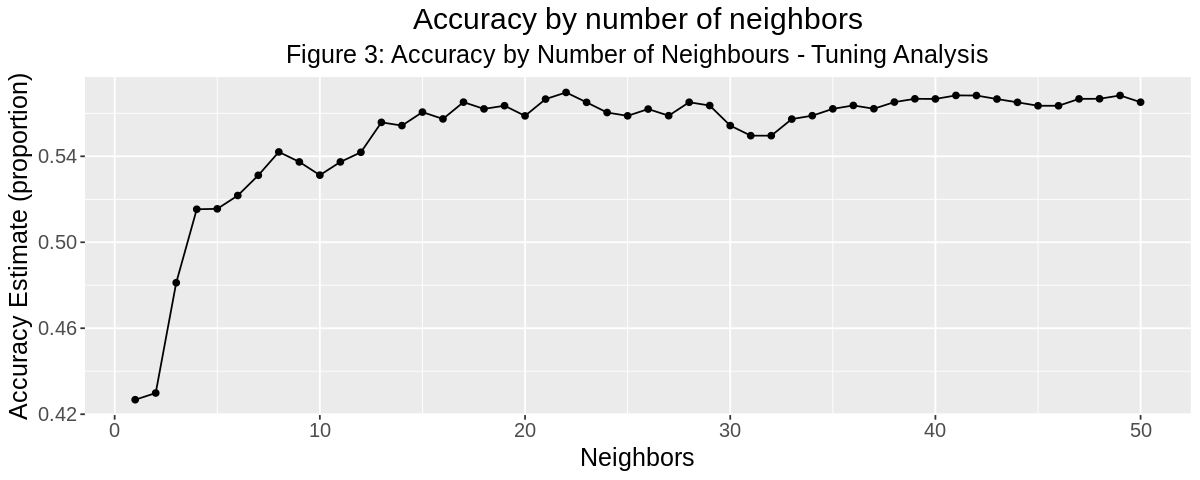

In [10]:
options(repr.plot.width = 10, repr.plot.height = 4)

k_vs_acc_plot <- heart_disease_results |>
                    filter(.metric == 'accuracy') |>
                    select(neighbors, mean) |>
                    ggplot(aes(x = neighbors, y = mean)) +
                        geom_point() +
                        geom_line() +
                        labs(x = "Neighbors", y = "Accuracy Estimate (proportion)") +
                        ggtitle("Accuracy by number of neighbors",
                               subtitle = "Figure 3: Accuracy by Number of Neighbours - Tuning Analysis") +
                        theme(text= element_text(size =15), plot.title = element_text(hjust = 0.5), plot.subtitle = element_text(hjust = 0.5))
k_vs_acc_plot

To analyze our model’s performance in more detail, we created Figure 4 which compares the number of true cases to the number of predicted cases to the number of correctly predicted cases for each chest pain type. Figure 4 highlights a large problem with our classifier. That is, our classifier appeared to be essentially defaulting to classifying observations as asymptomatic, likely due to the greater number of asymptomatic cases in tandem with the lack of distinction between classes. The issue being that although the classifier may be able to identify an asymptomatic case with somewhat reasonable accuracy, it would not be able to classify anginal and non-anginal cases with any reasonable accuracy.

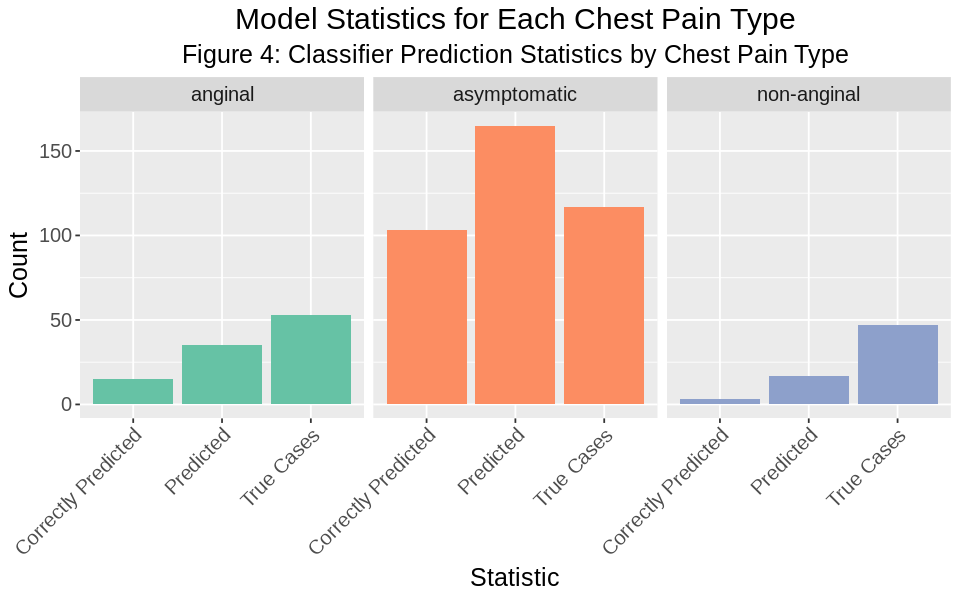

In [11]:
set.seed(1234)
options(repr.plot.width = 8, repr.plot.height = 5)


num_cases_test <- heart_disease_test |>
                    group_by(cp_type) |>
                    summarize(type = "True Cases", count = n())



predicted_class <- heart_disease_best_fit |>
    predict(heart_disease_test)


predicted_count <- predicted_class |>
                        mutate(cp_type = .pred_class)|>
                        group_by(cp_type) |>
                        summarize(type = "Predicted", count = n())

correct_predictions <- predicted_class |> 
                        bind_cols(heart_disease_test) |> 
                        select(.pred_class, cp_type) |> 
                        filter(cp_type == .pred_class) |>
                        group_by(cp_type) |>
                        summarize(type = "Correctly Predicted", count = n())



summary_tbl <- bind_rows(num_cases_test, predicted_count, correct_predictions)


summary_graph <- summary_tbl |>
                    ggplot(aes(x= type, y = count, fill = cp_type)) +
                        geom_bar(stat = "identity", show.legend = FALSE) +
                        ggtitle("Model Statistics for Each Chest Pain Type",
                               subtitle = "Figure 4: Classifier Prediction Statistics by Chest Pain Type")+
                        labs(x = "Statistic", y = "Count") +
                        facet_grid(cols = vars(cp_type)) +
                        scale_fill_brewer(palette= "Set2") +
                        theme(text = element_text(size = 15), 
                              plot.title = element_text(hjust = 0.5), 
                              axis.text.x = element_text(angle = 45, hjust=1),
                              plot.subtitle = element_text(hjust = 0.5))

summary_graph

## **Discussion**

After designing, tuning, and refining our KNN classification model, we found that it achieved an accuracy of about 56% on test data. We also found that it was significantly worse at predicting anginal and non-anginal cases than asymptomatic cases.

These results, though disappointing, were expected. Our exploratory data analysis makes it apparent that our predictor variables were not good determinants of chest pain type. The range and distribution of values for all chest pain types were quite similar for all predictors. This is most clear in Figure 1 where we can see all observations in one jumbled cluster with no distinct subgroups. Figures 2.1-2.3 mirror the sentiment, showing highly similar trends for all three chest pain types in each predictor-predictor relationship.

However, it serves to mention that the predictor variables we chose were three of only four or five useable predictor variables given that we were using a KNN classification model. As such, despite knowing that our classifier would likely perform poorly, we didn’t have many other options by nature of the data set and the tools currently available to us.

With that in mind, there are ways in which the accuracy of our classifier could have been improved. Firstly, it could have been improved by finding a dataset with more useable data and fewer missing or otherwise unusable values, as we would have had more good-quality predictors to choose from (given our KNN classification model). Secondly, it could have been improved by using a more powerful/appropriate classification model, as the algorithm would have been superior and we likely would have been able to use more variables from our data set (e.g., factor variables). One such more powerful/appropriate model is the Random Forest model. With more complex processes such as incorporating multivariate predictors, better results could be obtained using the Random Forest model. In fact, a study using the Random Forest classification algorithm produced an accuracy of 89.4% when predicting heart disease (Ahmed, 2022).

The low accuracy and overall performance of our classifier renders it ineffective for any practical application and indicates that it cannot provide much insight into correlations between our predictors and chest pain type. However, our findings could inform the design (e.g., model type, predictors, etc.) of future chest pain type and heart disease classifiers. Considering that accurate classification of chest pain type could lead to earlier detection of heart issues and more timely treatment, a well-performing classification model could have a substantial impact in healthcare.

Our model’s results, alongside the general topic of computer algorithms in medicine, spark many questions. First, given the low classification accuracy with our chosen predictors, one might ask which health metric influences chest pain type the most? Second, in light of racial biases present in currently employed medical algorithms which lead to unequal care of underserved populations (Obermeyer, 2019), one might ask about the ethical and social implications of using computer algorithms in healthcare. Third, one might inquire about the cybersecurity concerns of more readily storing and utilizing big data sets containing sensitive personal health inormation.


## **References (APA Style)**

Ahmed, I. (2022). A study of heart disease diagnosis using machine learning and datamining. *Electronic Theses, Projects, and Dissertations*,  1591. https://scholarworks.lib.csusb.edu/etd/1591 

Janosi, A., Steinbrunn, W., Pfisterer, M., & Detrano, R. (1988). Heart Disease. *UCI Machine Learning Repository*. https://doi.org/10.24432/C52P4X.

Obermeyer, Z., Powers, B., Vogeli, C. & Mullainathan, S. (2019). Dissecting racial bias in an algorithm used to manage the health of populations. Science, 366(6464), 447-453. https://doi.org/10.1126/science.aax2342

Smith, S. C., Collins, A., Ferrari, R., Holmes, D. R., Logstrup, S., McGhie, D. V., Ralston, J., Sacco, R. L., Stam, H., Taubert, K., Wood, D. A., & Zoghbi, W. A. (2012). Our time: A call to save preventable death from cardiovascular disease (heart disease and stroke). *Circulation*, 126(23), 2769–2775. https://doi.org/10.1161/cir.0b013e318267e99f 